# Estimating Causal Effect towards individual Resilience to risks globally
Code authored by: Minh Kieu, UoA, 2023 <br />
EconML Library<br />
Data from: https://wrp.lrfoundation.org.uk

#### Version 2:
- We do not remove variables that are already in the Perception and Experience indices

### Import libraries

In [3]:
#data modules
import pandas as pd 
import pickle
import pyreadstat
import numpy as np

#Causal Discover modules
from pgmpy.estimators import HillClimbSearch, BicScore
import networkx as nx
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout

#Causal Inference modules
from sklearn.ensemble import RandomForestRegressor
import econml
import dowhy
from dowhy import CausalModel

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt




### Load data


In [4]:
df, meta = pyreadstat.read_sav("../Data/lrf_wrp_2021_full_data.sav")
#filter out countries with number of data points less than 1200
df = df.groupby('Country').filter(lambda x: x['Country'].count() >= 1200)

#drop all columns from 'resilience_index' to 'Q5F_2019'
df = df.drop(df.loc[:,'resilience_index':'Q5F_2019'].columns, axis=1)
cols_to_remove = ['WPID_RANDOM','WP5','WGT','Year','country.in.both.waves','CountryIncomeLevel2019','PROJWT_2021','PROJWT_2019','AgeGroups4']
df= df.drop(cols_to_remove, axis=1)

df.head(2)

,Country,GlobalRegion,CountryIncomeLevel2021,Age,Gender,Education,IncomeFeelings,INCOME_5,EMP_2010,Urbanicity,...,Q22A,Q22B,Q22C,Q22D,Q22E,Q23A,Q23B,Q23C,Q23D,Q23E
0,United States,6.0,4.0,70.0,1.0,1.0,2.0,2.0,6.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,United States,6.0,4.0,56.0,1.0,3.0,1.0,5.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [5]:
df.columns

Index(['Country', 'GlobalRegion', 'CountryIncomeLevel2021', 'Age', 'Gender',
       'Education', 'IncomeFeelings', 'INCOME_5', 'EMP_2010', 'Urbanicity',
       'HouseholdSize', 'ChildrenInHousehold', 'Q1', 'Q2_1', 'Q3', 'Q4A',
       'Q4B', 'Q4C', 'Q4D', 'Q4E', 'Q4F', 'Q4G', 'Q5A', 'Q5B', 'Q5C', 'Q5D',
       'Q5E', 'Q5F', 'Q5G', 'Q6', 'Q7A', 'Q7C', 'Q8', 'Q9', 'Q10', 'Q11_1',
       'Q11_2', 'Q10Q11Recode', 'Q13', 'Q14A', 'Q14B', 'Q14C', 'Q14D', 'Q14E',
       'Q14F', 'Q14G', 'Q15', 'Q16A', 'Q16B', 'Q16C', 'Q16D', 'Q17', 'Q18_1',
       'Q19A', 'Q19B', 'Q19C', 'Q19D', 'Q20', 'Q21', 'Q22A', 'Q22B', 'Q22C',
       'Q22D', 'Q22E', 'Q23A', 'Q23B', 'Q23C', 'Q23D', 'Q23E'],
      dtype='object')

In [56]:
cols_to_replace = ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']
replace_dict = {98: np.nan, 99: np.nan}
df[cols_to_replace] = df[cols_to_replace].replace(replace_dict)

#removing the raws if all the columns have missing values, 98, 99 
df.dropna(subset=['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G'], thresh=7, inplace=True)


Convert data to largely numeric columns

In [57]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 1 else 0).astype('uint8')

#Remove the don't know or refuse to answer samples
df['ChildrenInHousehold']=df['ChildrenInHousehold'].astype('uint8')
df['Country']=df['Country'].astype('category')
df['GlobalRegion']=df['GlobalRegion'].astype('uint8')

cols_to_replace = ['INCOME_5']
replace_dict = {98: np.nan, 99: np.nan}
df[cols_to_replace] = df[cols_to_replace].replace(replace_dict)
df['INCOME_5']=df['INCOME_5'].fillna(df['INCOME_5'].median())
df['IncomeFeelings']=df['IncomeFeelings'].fillna(df['IncomeFeelings'].median())
df.loc[:, ['INCOME_5']] = df.loc[:, ['INCOME_5']].replace({5: 1, 4: 0.8, 3: 0.6, 2:0.4, 1:0.2}).astype('float')

df = df.loc[df['IncomeFeelings']<5,:]
df.loc[:, ['IncomeFeelings']] = df.loc[:, ['IncomeFeelings']].replace({2: 0.5, 3:0.25, 4: 0}).astype('float')

df['EMP_2010']=df['EMP_2010'].fillna(df['EMP_2010'].median())
df['EMP_2010']=df['EMP_2010'].astype('uint8')
df['Age'] = df['Age'].astype('uint8')
df = df.loc[df['Age']<100,:]
df = df.loc[df['Education']<9,:]
df['Education']=df['Education'].astype('uint8')
df = df.loc[df['Urbanicity']<9,:]
df['Urbanicity']=df['Urbanicity'].astype('uint8')

columns_to_filter = ['Q8','Q14A','Q14B','Q14C','Q14D','Q14E','Q14F','Q14G','Q17','Q22A','Q22B','Q22C','Q22D','Q23A','Q23B','Q23C','Q23D','Q23E']

for col in columns_to_filter:
    df.loc[df[col] >= 9, col] = None  # Replace values larger than or equal to 9 with None (or some other value)


#Convert some categorical data into numeric
col_to_fil = ['Q1','Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G','Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G','Q9','Q8']
df[col_to_fil]=df[col_to_fil].fillna(df[col_to_fil].median())

df.loc[:, ['Q1']] = df.loc[:, ['Q1']].replace({3: 1, 2: 0, 98: 0, 99: 0}).astype('uint8')
df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']] = df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']].replace({2: 0.5, 3: 0, 98: 0, 99: 0}).astype('float')
df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']] = df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].replace({3: 1, 1: 0.75, 2: 0.5, 4: 0, 98: 0, 99: 0}).astype('float')
df.loc[:, ['Q9']] = df.loc[:, ['Q9']].replace({2: 0, 3: 0.5, 4: 0.5, 98: 0.5, 99: 0.5})
df.loc[:, ['Q8']] = df.loc[:, ['Q8']].replace({2: 0}).astype('float')

columns_to_replace = ['Q14A','Q14B','Q14C','Q14D','Q14E','Q14F','Q14G','Q17','Q22A','Q22B','Q22C','Q22D','Q23A','Q23B','Q23C','Q23D','Q23E']
df[columns_to_replace]=df[columns_to_replace].fillna(df[columns_to_replace].median())
df.loc[:,columns_to_replace] = df.loc[:,columns_to_replace].replace({2: 0})
df[columns_to_replace] = df[columns_to_replace].astype('uint8')



## Step 1: Estimate the values of Perception, Experience and Resilience index

#### For given risk (eg: crime)
$$\text{Perception Index (given country)} = \text{avg of individual perception scores of a country}$$
$$\text{Experience Index (given country)} = \text{avg of individual experience scores of a country}$$
$$\text{Risk Impact Index (individual)} = \text{experience score} \times \text{perception score}$$


#### Resilience index for all seven risks
$$\text{Resilience Index (individual)} = \text{Average of all the individual response to Resilience-related questions} $$

- To calculate the perception score, the weitages are  very worried = 1, somewhat worried = 0.5, not worried = 0, and DK & refused = missing 

- To calculate the experience score, the weitages are  Both = 1, Yes,personally experienced = 0.75, Yes,know someone who has experienced = 0.5, No = 0, and DK & refused = missing 

### Step 1.1: First, let's estimate the Perception, Experience and Risk Impact Index

In [58]:
# define a function to compute the average of the non-ignored values in each row for perception score (worry) and experience score)
def compute_average(row):
    valid_values = [value for value in row if not pd.isna(value)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan

# create a new column with the computed average
df['Perception_index'] = df.loc[:, ['Q4A', 'Q4B','Q4C','Q4D', 'Q4E','Q4F','Q4G']].apply(compute_average, axis=1)
df['Experience_index'] = df.loc[:, ['Q5A','Q5B','Q5C','Q5D','Q5E','Q5F','Q5G']].apply(compute_average, axis=1)
df['Impact_index'] = df['Perception_index'] * df['Experience_index']
df.head(2)


,Country,GlobalRegion,CountryIncomeLevel2021,Age,Gender,Education,IncomeFeelings,INCOME_5,EMP_2010,Urbanicity,...,Q22D,Q22E,Q23A,Q23B,Q23C,Q23D,Q23E,Perception_index,Experience_index,Impact_index
0,United States,6,4.0,70,1,1,0.5,0.4,6,2,...,0,2.0,0,0,0,0,0,0.642857,0.0,0.0
1,United States,6,4.0,56,1,3,1.0,1.0,1,1,...,0,2.0,0,0,0,0,0,0.214286,0.0,0.0


Now we can drop the individual questions related to Perception and Experience 

### Step 1.2: Now let' estimate the value of Resilience index

In [59]:
#index_resi=df[['GlobalRegion','Country', 'Q20', 'Q21','Q10Q11Recode','Q16C', 'Q13','Q16D','Q16A','Q16B']].copy()

# replace DOn't know and Refuse to answer to NaN
cols_to_replace = ['Q20', 'Q21','Q10Q11Recode','Q16C', 'Q13','Q16D','Q16A','Q16B']
replace_dict = {98: np.nan, 99: np.nan}
df[cols_to_replace] = df[cols_to_replace].replace(replace_dict)

# replace the values 2 with 0.5 and 3 with 0
df.loc[:, ['Q13']] = df.loc[:, ['Q13']].replace({2: 0.5, 3: 0})
df.loc[:, ['Q10Q11Recode']] = df.loc[:, ['Q10Q11Recode']].replace({1: 0.1, 2: 0.2, 3: 0.3, 4: 0.4, 5: 0.5, 6: 0.8, 7: 0.9, 8: 1, 9: 0.7})
df.loc[:, ['Q20','Q16D','Q16A','Q16B','Q16C']] = df.loc[:, ['Q20','Q16D','Q16A','Q16B','Q16C']].replace({3: 0.5, 2: 0})
df.loc[:, ['Q21']] = df.loc[:, ['Q21']].replace({2: 0})

# define a function to compute the average of the non-ignored values in each row for perception score (worry) and experience score)
def compute_average(row):
    valid_values = [value for value in row if not pd.isna(value)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan

# Calculating individual resilience score
df['Resilience_index'] = df.loc[:, cols_to_replace].apply(compute_average, axis=1)
df.head(2)

,Country,GlobalRegion,CountryIncomeLevel2021,Age,Gender,Education,IncomeFeelings,INCOME_5,EMP_2010,Urbanicity,...,Q22E,Q23A,Q23B,Q23C,Q23D,Q23E,Perception_index,Experience_index,Impact_index,Resilience_index
0,United States,6,4.0,70,1,1,0.5,0.4,6,2,...,2.0,0,0,0,0,0,0.642857,0.0,0.0,0.725
1,United States,6,4.0,56,1,3,1.0,1.0,1,1,...,2.0,0,0,0,0,0,0.214286,0.0,0.0,0.850


In [60]:
# Drop variables that are already in the Resilience Index
df = df.drop(['Q10','Q11_1','Q11_2','Q20', 'Q21','Q10Q11Recode','Q16C', 'Q13','Q16D','Q16A','Q16B'],axis=1)

Now let's do some more data cleaning by removing variables with a lot of missing values, then fill remaining NaNs with the mean value of the column

In [61]:
# specifically keep the Q4G
df['Q4G']=df['Q4G'].fillna(df['Q4G'].mean())
# then filter the rest
df=df.dropna(thresh=df.shape[0]*0.3,how='all',axis=1)
df=df.fillna(df.mean())
df.columns

Index(['Country', 'GlobalRegion', 'CountryIncomeLevel2021', 'Age', 'Gender',
       'Education', 'IncomeFeelings', 'INCOME_5', 'EMP_2010', 'Urbanicity',
       'HouseholdSize', 'ChildrenInHousehold', 'Q1', 'Q2_1', 'Q3', 'Q4A',
       'Q4B', 'Q4C', 'Q4D', 'Q4E', 'Q4F', 'Q4G', 'Q5A', 'Q5B', 'Q5C', 'Q5D',
       'Q5E', 'Q5F', 'Q5G', 'Q6', 'Q7A', 'Q7C', 'Q8', 'Q9', 'Q14A', 'Q14B',
       'Q14C', 'Q14D', 'Q14E', 'Q14F', 'Q14G', 'Q15', 'Q17', 'Q22A', 'Q22B',
       'Q22C', 'Q22D', 'Q22E', 'Q23A', 'Q23B', 'Q23C', 'Q23D', 'Q23E',
       'Perception_index', 'Experience_index', 'Impact_index',
       'Resilience_index'],
      dtype='object')

In [62]:
df.columns = ['Country', 'Region', 'CountryIncome', 'Age', 'Gender','Education', 'IncomePerception',
       'IncomeBracket', 'Employment', 'Urbanicity', 'HouseholdSize','Child', 'isSafer','GreatestRisk','ClimateChange',
       'WorryFood','WorryWater','WorryCrime','WorryWeather','WorryRoadCrash','WorryMental','WorryWork',
       'Exp_Food','Exp_Water','Exp_Crime','Exp_Weather','Exp_RoadCrash','Exp_Mental','Exp_Work',
       'UsedInternet','WorryInfoStolen','WorryInfoUsed','AV_Trust','AI_Trust', 
       'Info_weather', 'Info_agency', 'Info_News', 'Info_religion', 'Info_famous', 'Info_services', 'Info_internet',
       'TrustMost','Exp_Disaster',
       'Exp_NoElectric','Exp_NoWater','Exp_NoFood','Exp_NoMeds','Exp_NoTel',
       'Dis_Skin', 'Dis_Religion', 'Dis_Ethic', 'Dis_Gender',
       'Dis_Disability', 'Perception_ind', 'Impact_ind','Experience_ind','Resilience_ind']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120680 entries, 0 to 125910
Data columns (total 57 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Country           120680 non-null  category
 1   Region            120680 non-null  uint8   
 2   CountryIncome     120680 non-null  float64 
 3   Age               120680 non-null  uint8   
 4   Gender            120680 non-null  uint8   
 5   Education         120680 non-null  uint8   
 6   IncomePerception  120680 non-null  float64 
 7   IncomeBracket     120680 non-null  float64 
 8   Employment        120680 non-null  uint8   
 9   Urbanicity        120680 non-null  uint8   
 10  HouseholdSize     120680 non-null  float64 
 11  Child             120680 non-null  uint8   
 12  isSafer           120680 non-null  uint8   
 13  GreatestRisk      120680 non-null  float64 
 14  ClimateChange     120680 non-null  float64 
 15  WorryFood         120680 non-null  float64 
 16  Wo

In [63]:
with open("../Data/df_processed.pkl", 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

## Step 2: Perform Causal Discovery using a Bayesian Network

Bayesian networks (BNs) can be used for causal discovery from observational data. In fact, they are one of the primary tools for this task.

A Bayesian network is a directed acyclic graph (DAG) that represents the joint probability distribution over a set of variables. Each node in the graph corresponds to a variable, and the edges between the nodes represent probabilistic dependencies between the variables.

Causal discovery is primarily concerned with the first phase of Bayesian network modeling, which is learning the structure or the graphical representation. The learned graph from this phase often represents a causal structure, where the nodes represent variables and the edges represent causal relationships.

The structural learning process is able to identify these relationships and the direction of influence based on the patterns and dependencies in the data, which makes it a powerful tool for causal discovery.

However, it's important to note that while this structure can suggest causal relationships, it does not definitively prove them. There might be hidden or latent variables not included in the data that can influence the relationships. Therefore, any causal conclusions should be drawn cautiously and, ideally, should be supported by domain knowledge or further experimentation.


#### first, let's try HillClimbing Search to develop the DAG



In [64]:
# Use Hill Climb Search to develop the BN structure, then BicScore to estimate the parameters for our BN
np.random.seed(123)  # Set the seed to an arbitrary number
hc = HillClimbSearch(df)
bic = BicScore(df)
best_model = hc.estimate(scoring_method=bic)

  0%|          | 132/1000000 [14:52<1876:57:57,  6.76s/it]


In [65]:
G = nx.DiGraph()
G.add_edges_from(best_model.edges())

# Use pygraphviz to create the layout
pos = graphviz_layout(G, prog='neato')

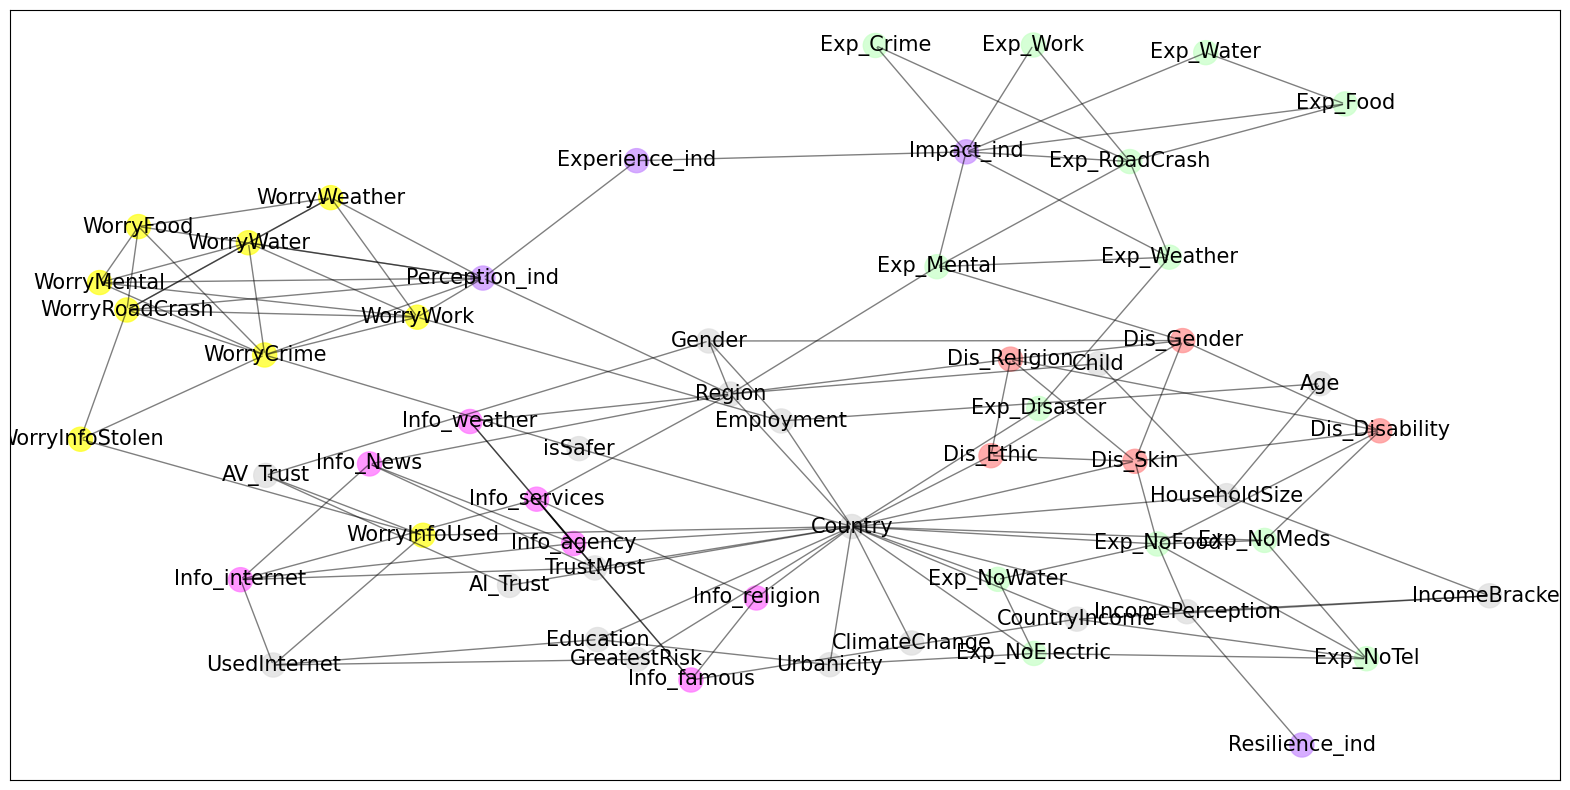

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))


# assign colors to nodes based on their names
colors = []
for node in G.nodes():
    if 'Without' in node:
        colors.append('#9999FF')
    elif '_ind' in node:
        colors.append('#CC99FF')
    elif 'Info_' in node:
        colors.append('#FF7DFF')
    elif 'Dis_' in node:
        colors.append('#FF9999')
    elif 'Exp_' in node:
        colors.append('#CCFFCC')
    elif 'Worry' in node:
        colors.append('#FFFF2B')
    else:    
        colors.append('#E0E0E0')

# Offset the labels to avoid overlaps
pos_labels = {node: (x, y - 10) for node, (x, y) in pos.items()}

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=300, node_color=colors, alpha=0.8, ax=ax)

# Draw edges with transparency
for (u, v) in G.edges():
    ax.annotate("", xy=pos[v], xytext=pos[u],
                arrowprops=dict(arrowstyle="-", alpha=0.5, lw=1))

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=15, ax=ax)

plt.savefig('../Figures/causalnetwork.pdf',bbox_inches='tight')
plt.show()

In [67]:
with open("../Data/DAG.gpickle", 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

# load later by using:
#with open("../Data/DAG.gpickle", 'rb') as f:
#    G = pickle.load(f)


Try to learn the DAG structure using the PC (Constraint-based Search) instead

### Note: Only run on a HPC as this method takes forever! 

In [ ]:
#from pgmpy.estimators import PC

# Use Hill Climb Search to develop the BN structure, then BicScore to estimate the parameters for our BN
#hc = PC(df2)
#bic = BicScore(df2)
#best_model = hc.estimate(scoring_method=bic)


## Step 3: Estimating Causal Effects with DoWhy 

Code adopted from: https://microsoft.github.io/dowhy/example_notebooks/dowhy-conditional-treatment-effects.html

#### Step 3.1: causal model for Impact index

Load the finished DAG if you have run it

In [11]:
# load later by using:
with open("../Data/DAG.gpickle", 'rb') as f:
    G = pickle.load(f)



EOFError: Ran out of input

In [6]:
with open("../Data/df_processed.pkl", 'rb') as f:
    df = pickle.load(f)

df = df.dropna()

In [3]:
#subpress the warnings
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [13]:
from econml.dml import CausalForestDML

# Define outcome
Y = df['Impact_ind'].values.ravel()

# Define treatments
T = df[['Exp_RoadCrash','Exp_Water','Exp_Work','Exp_Food','Exp_Crime','Exp_Mental','Exp_Weather']]

# Select all numeric variables
relevant_variables = df.select_dtypes(include=['float64', 'int64','uint8']).columns.tolist()

# Make sure to remove the outcome and treatment variables from relevant_variables
# assuming 'Impact_ind' is your outcome variable and treatments are as defined
relevant_variables = [var for var in relevant_variables if var not in ['Perception_ind', 'Impact_ind', 'Experience_ind', 'Resilience_ind', 'IncomePerception']]

  
# Define control variables
W = df[relevant_variables]
  
# Initialize a StandardScaler instance

scaler = StandardScaler()

# Fit the scaler on the control variables and transform them
W_scaled = scaler.fit_transform(W)

# Specify models

model_y = RandomForestRegressor()
model_t = RandomForestRegressor()

# Define the Causal Forest estimator
est = CausalForestDML(model_y=model_y, model_t=model_t, featurizer=PolynomialFeatures(degree=1))

# Fit the model
est.fit(Y, T, X=W_scaled, W=W_scaled)

In [14]:
# Calculate the constant marginal effect for these instances
const_marginal_effect = est.const_marginal_effect(X=W_scaled).ravel()
const_marginal_effect
df['cate_impact'] = pd.Series(const_marginal_effect)

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


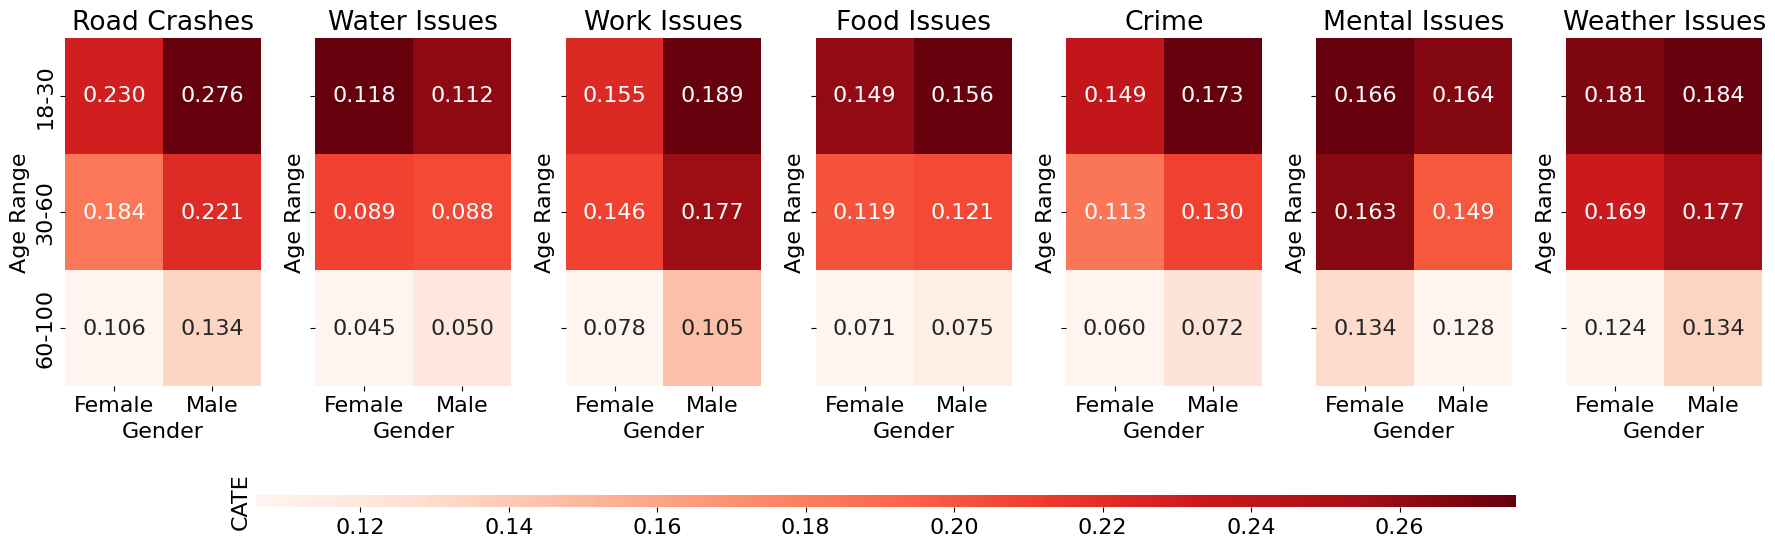

In [31]:
plt.rcParams.update({'font.size': 16})

age_ranges = [(18, 30), (30, 60), (60, 100)]
genders = [0, 1]  # Assuming Gender is binary: 0 or 1
treatments = ['Exp_RoadCrash','Exp_Water','Exp_Work','Exp_Food','Exp_Crime','Exp_Mental','Exp_Weather']

# Initialize empty DataFrame to hold CATE values for visualization
cate_impact_df = pd.DataFrame(columns=['Age_Min', 'Age_Max', 'Gender', 'Treatment', 'CATE'])

# Loop through each age range and gender
for age_min, age_max in age_ranges:
    for gender in genders:
        # Define the key for this subset
        key = f'Age_{age_min}_{age_max}_Gender_{gender}'
        #print(key)
        
        # Subset data for the given age range and gender
        df_subset = df.loc[df['Age'].between(age_min, age_max) & (df['Gender'] == gender),treatments].reset_index(drop=True)
        #print(df_subset)

        for treatment_idx, treatment in enumerate(treatments):

            cate_value = np.mean(df_subset.iloc[:, treatment_idx])  # Averaging CATE values if there are multiple
            cate_impact_df = cate_impact_df.append({
                'Age_Min': age_min,
                'Age_Max': age_max,
                'Gender': gender,
                'Treatment': treatment,
                'CATE': cate_value
            }, ignore_index=True)

# Create subplots
fig, axes = plt.subplots(1, 7, figsize=(18, 6), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Positioning of the colorbar at the bottom

# Define friendly names for the treatments and genders
friendly_treatment_names = {
    'Exp_RoadCrash': 'Road Crashes',
    'Exp_Water': 'Water Issues',
    'Exp_Work': 'Work Issues',
    'Exp_Food': 'Food Issues',
    'Exp_Crime': 'Crime',
    'Exp_Mental': 'Mental Issues',
    'Exp_Weather': 'Weather Issues'
}
friendly_gender_names = {1: 'Male', 0: 'Female'}


# Loop through each treatment to create individual subplots
for idx, treatment in enumerate(treatments):
    ax = axes[idx]
    data = cate_impact_df[cate_impact_df['Treatment'] == treatment].pivot_table(
        values='CATE', index=['Age_Min', 'Age_Max'], columns='Gender'
    )
    sns.heatmap(data, ax=ax, cmap='Reds', annot=True, cbar=(idx == 0), cbar_ax=cbar_ax, cbar_kws={'orientation': 'horizontal'}, fmt=".3f")
    
    ax.set_title(friendly_treatment_names[treatment])
    ax.set_xlabel('Gender')
    ax.set_ylabel('Age Range')
    ax.set_xticklabels([friendly_gender_names[int(label.get_text())] for label in ax.get_xticklabels()])

# Set color bar label
cbar_ax.set_ylabel('CATE')

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('../Figures/CATE_Impact_GenderAge.pdf')
plt.show()

#### Step 3.3: Causal estimation for Resilience index

In [4]:
from econml.dml import CausalForestDML

# Define outcome
Y = df['Resilience_ind'].values.ravel()
Y = np.ravel(Y)  # Make sure it's a 1D array
# Define treatments
T = df[['IncomePerception']]

# Specify the variables you believe are more directly correlated

# Select all numeric variables
relevant_variables = df.select_dtypes(include=['float64', 'int64','uint8']).columns.tolist()

# Make sure to remove the outcome and treatment variables from relevant_variables
# assuming 'Impact_ind' is your outcome variable and treatments are as defined
relevant_variables = [var for var in relevant_variables if var not in ['Perception_ind', 'Impact_ind', 'Experience_ind', 'Resilience_ind', 'IncomePerception']]

# Define control variables
W = df[relevant_variables]
  
# Initialize a StandardScaler instance

scaler = StandardScaler()

# Fit the scaler on the control variables and transform them
W_scaled = scaler.fit_transform(W)

# Specify models

model_y = RandomForestRegressor()
model_t = RandomForestRegressor()

# Define the Causal Forest estimator
est = CausalForestDML(model_y=model_y, model_t=model_t, featurizer=PolynomialFeatures(degree=1))

# Fit the model
est.fit(Y, T, X=W_scaled, W=W_scaled)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [5]:
# Calculate the constant marginal effect for these instances
const_marginal_effect = est.const_marginal_effect(X=W_scaled).ravel()
const_marginal_effect
df['cate'] = pd.Series(const_marginal_effect)

In [6]:
countries = df['Country'].unique()  


# Initialize a DataFrame to store the country-wise average CATE estimates
cate_df = pd.DataFrame(columns=['Country', 'CATE'])

# Loop through each country
for country in countries:
    
    # Subset data for the given country
    df_subset = df[df['Country'] == country]
    
    # Calculate the average CATE for this subset (if const_marginal_effect_subset is a multi-dimensional array, you might need to index it appropriately)
    avg_cate = np.mean(df_subset['cate'])
    
    # Store the average CATE in the DataFrame
    cate_df = cate_df.append({'Country': country, 'CATE': avg_cate}, ignore_index=True)

# Export the DataFrame
cate_df.to_csv('average_cate_by_country.csv', index=False)


In [7]:
import geopandas as gpd

regions = gpd.read_file("../shapefiles/World_Countries__Generalized_.shp")
regions = regions[regions['COUNTRY'] != 'Antarctica']
regions = regions[['COUNTRY','geometry']]
regions['COUNTRY'] = regions['COUNTRY'].replace('Russian Federation', 'Russia')
regions['COUNTRY'] = regions['COUNTRY'].replace('Bosnia and Herzegovina', 'Bosnia Herzegovina')
regions['COUNTRY'] = regions['COUNTRY'].replace('Congo', 'Congo Brazzaville')
regions['COUNTRY'] = regions['COUNTRY'].replace('Palestinian Territory', 'Palestine')
regions['COUNTRY'] = regions['COUNTRY'].replace('Turkiye', 'Turkey')
regions['COUNTRY'] = regions['COUNTRY'].replace("Côte d'Ivoire", 'Ivory Coast')
regions

#cate_df = df[['Country','Region','cate']]

# Merge world data base with Risk Poll data base
merged = regions.merge(cate_df, left_on='COUNTRY', right_on='Country')
#merged = merged.drop(merged[merged['Q2_1'] > 25].index)
merged


,COUNTRY,geometry,Country,CATE
0,Afghanistan,"POLYGON ((61.27655 35.60725, 61.29638 35.62854...",Afghanistan,0.105110
1,Albania,"POLYGON ((19.57083 41.68527, 19.58195 41.69569...",Albania,0.103537
2,Algeria,"POLYGON ((4.60335 36.88791, 4.63555 36.88638, ...",Algeria,0.098612
3,Argentina,"MULTIPOLYGON (((-71.85916 -41.01128, -71.83806...",Argentina,0.102244
4,Armenia,"MULTIPOLYGON (((46.54037 38.87559, 46.51639 38...",Armenia,0.113975
...,...,...,...,...
110,Uzbekistan,"POLYGON ((68.64267 39.85824, 68.63721 39.83943...",Uzbekistan,NaN
111,Venezuela,"MULTIPOLYGON (((-66.31029 10.62602, -66.28309 ...",Venezuela,0.105128
112,Vietnam,"MULTIPOLYGON (((107.07896 17.10804, 107.08333 ...",Vietnam,0.106554
113,Zambia,"POLYGON ((30.21302 -14.98172, 30.21916 -15.096...",Zambia,0.109499


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


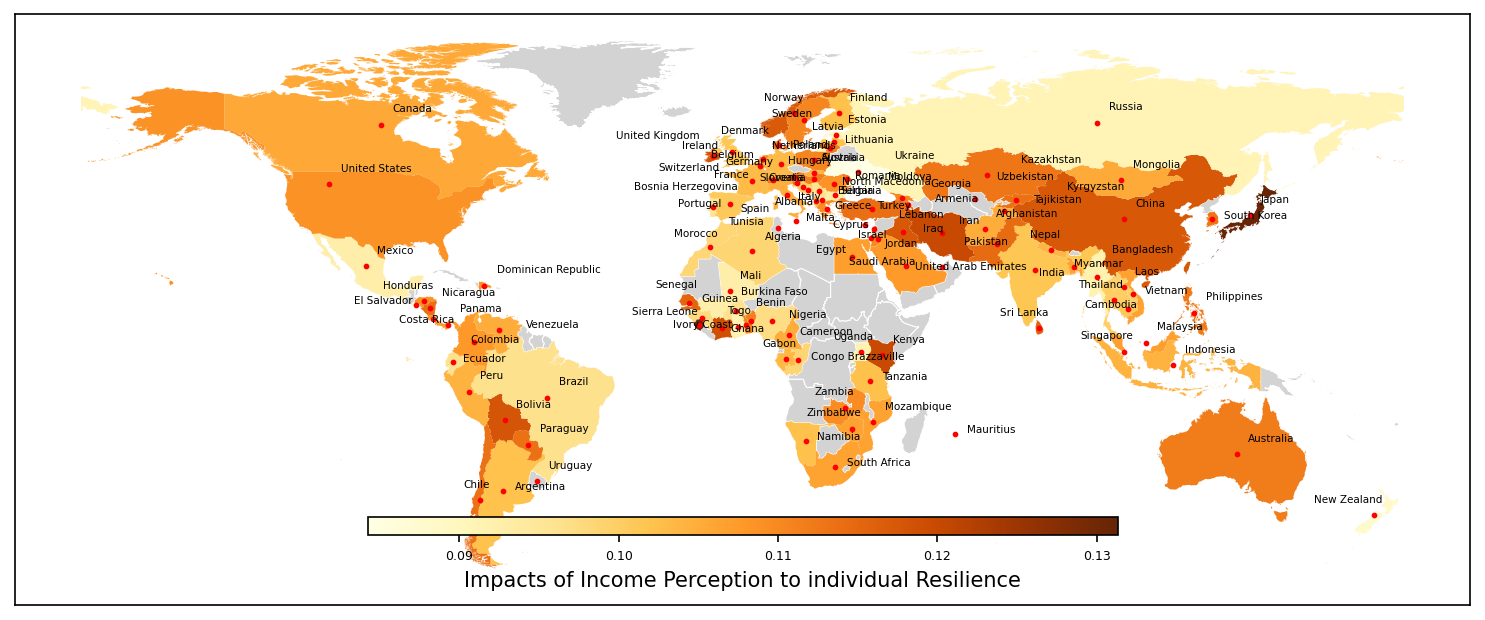

In [10]:
import matplotlib as mpl
import matplotlib.colorbar as mcb
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Set the size of the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Plot the base map in grey color
regions.plot(ax=ax, facecolor='lightgrey', edgecolor='white', linewidth=0.5)

# Remove grids
ax.grid(False)

# CATE plot
cmap = mpl.cm.YlOrBr
cate_plot = merged.plot(ax=ax, column='CATE', cmap=cmap, legend=False)

# Create a colorbar within the main graph and make it horizontal
norm = plt.Normalize(merged['CATE'].min(), merged['CATE'].max())
cbar_ax = fig.add_axes([0.25, 0.25, 0.5, 0.02])  # Adjust the position and size of the colorbar
cbar = mcb.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.set_xlabel('Impacts of Income Perception to individual Resilience', fontsize=10)
cbar.ax.tick_params(labelsize=6)

# Add markers and store annotations in a list
texts = []
for idx, row in merged.iterrows():
    ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y, s=3, color='red')
    texts.append(ax.annotate(row['Country'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), xytext=(5, 5), textcoords='offset points', fontsize=5, color='black'))

# Optimize annotation positions to minimize overlaps
adjust_text(texts, ax=ax,force_text=0.01)   

# Hide the x-axis and y-axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig('../Figures/cate_map.pdf')
# Show the plot
plt.show()


## Step 4: Save the causal inference results

Note that the causal network DAG has already been saved to `DAG.gpickle`